In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Fragment count correlation

## Calculate by custom script

20221128	hg	all
19705 9493
20221128	hg	rmdup
19705 9184
20221128	gy	all
13968 6026
20221128	gy	rmdup
13968 5170
20221205	hg	all
19705 9618
20221205	hg	rmdup
19705 9339
20221205	gy	all
13968 3923
20221205	gy	rmdup
13968 3115


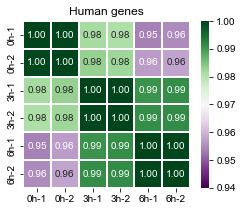

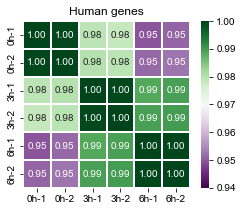

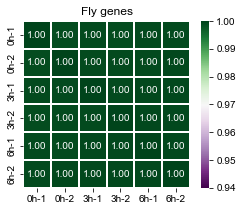

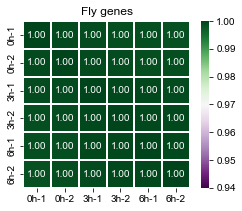

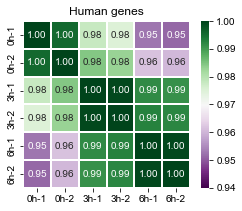

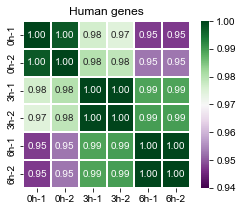

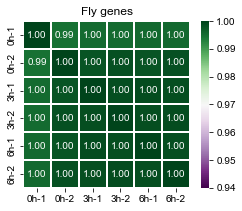

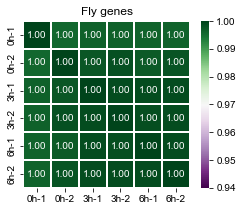

In [19]:
dates = ["20221128", "20221205"]
species_list = ["hg", "gy"]
columns = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]
sources = ["all", "rmdup"]

def stat_expr_corr(date, species, source):
    samples = []
    for t in [0, 3, 6]:
        for r in [1, 2]:
            s = "%s_K562_Actd_%dh_rep%d" % (date, t, r)
            samples.append(s)
    array = []
    for s, c in zip(samples, columns):
        path = "results/expression/fpkm/%s.%s.%s.tsv" % (s, species, source)
        d = pd.read_csv(path, sep="\t", index_col=0)
        d = d[(d["GeneType"] == "protein_coding") & (d["Canonical"])]
        d = d[~d["GeneName"].duplicated()]
        ss = d["Count"]
        ss.name = c
        ss.index = d["GeneName"]
        array.append(ss)
    dat = pd.concat(array, axis=1)
        
    tmp = dat[dat.mean(axis=1) >= 100]
    corr = tmp.corr()
    print(len(dat), len(tmp))
    
    vmin = 0.94
    
    plt.figure(figsize=(3.6, 3))
    if species == "hg":
        plt.title("Human genes")
    else:
        plt.title("Fly genes")
    # plt.title("Count corr (%s, %s, %s)" % (date, species, source))
    sns.heatmap(corr, cmap="PRGn", vmin=vmin, vmax=1, annot=True, fmt=".2f", lw=1, square=True)
    plt.tight_layout()
    # plt.show()
    plt.savefig("figures/fragment_count_corr.%s.%s.%s.pdf" % (date, species, source), dpi=300)
    # plt.close()
    
for date in dates:
    for species in species_list:
        for source in sources:
            print(date, species, source, sep="\t")
            stat_expr_corr(date, species, source)

## Calculate by featureCount

20221128	hg	all
61533 10096


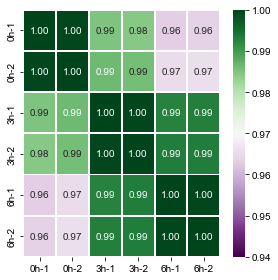

20221128	hg	rmdup
61533 9646


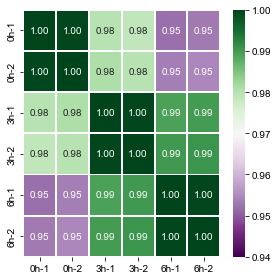

20221128	gy	all
23932 5950


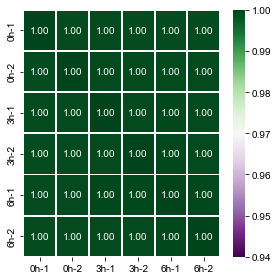

20221128	gy	rmdup
23932 5129


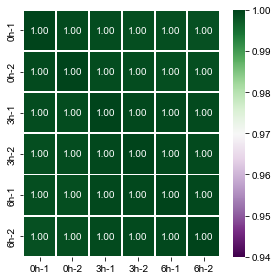

20221205	hg	all
61533 10305


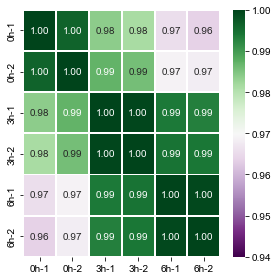

20221205	hg	rmdup
61533 9920


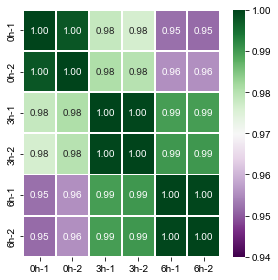

20221205	gy	all
23932 3986


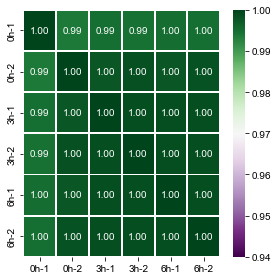

20221205	gy	rmdup
23932 3213


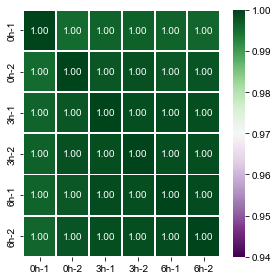

In [44]:
dates = ["20221128", "20221205"]
species_list = ["hg", "gy"]
columns = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]
sources = ["all", "rmdup"]

def stat_expr_corr(date, species, source):
    samples = []
    for t in [0, 3, 6]:
        for r in [1, 2]:
            s = "%s_K562_Actd_%dh_rep%d" % (date, t, r)
            samples.append(s)
    array = []
    for s, c in zip(samples, columns):
        path = "results/expression/feature_count/%s.%s.%s.tsv" % (s, species, source)
        d = pd.read_csv(path, sep="\t", index_col=0, comment="#")
        ss = d[d.columns[-1]]
        ss.name = "Count"
        ss.name = c
        array.append(ss)
    dat = pd.concat(array, axis=1)
    
    tmp = dat[dat.mean(axis=1) >= 100]
    corr = tmp.corr()
    print(len(dat), len(tmp))
    
    vmin = 0.94
    
    plt.figure(figsize=(4, 4))
    # plt.title("Count corr (%s, %s, %s)" % (date, species, source))
    sns.heatmap(corr, cmap="PRGn", vmin=vmin, vmax=1, annot=True, fmt=".2f", lw=1)
    plt.tight_layout()
    plt.show()
    # plt.savefig("figures/fragment_count_coree.%s.%s.%s.pdf" % (date, species, source), dpi=300)
    plt.close()
    
for date in dates:
    for species in species_list:
        for source in sources:
            print(date, species, source, sep="\t")
            stat_expr_corr(date, species, source)

# Estimate conversion factor

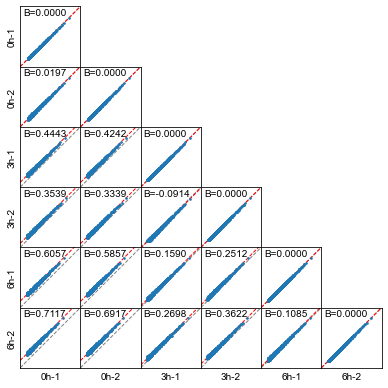

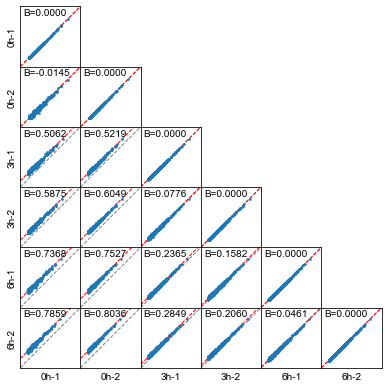

In [39]:
dates = ["20221128", "20221205"]
columns = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]

def get_k(xs, ys):
    xs = np.log(xs)
    ys = np.log(ys)
    b = (sum(ys) - sum(xs)) / len(xs)
    k = np.e ** b
    return k

def stat_conversion_factor(date):
    samples = []
    for t in [0, 3, 6]:
        for r in [1, 2]:
            s = "%s_K562_Actd_%dh_rep%d" % (date, t, r)
            samples.append(s)
    array = []
    for s, c in zip(samples, columns):
        path = "results/expression/fpkm/%s.gy.rmdup.tsv" % s
        d = pd.read_csv(path, sep="\t", index_col=0)
        d = d[(d["GeneType"] == "protein_coding") & (d["Canonical"])]
        d = d[~d["GeneName"].duplicated()]
        ss = d["Count"]
        ss.name = c
        ss.index = d["GeneName"]
        array.append(ss)
    dat = pd.concat(array, axis=1)
    
    factors = dict()
    fig, axs = plt.subplots(len(columns), len(columns), figsize=(5.5, 5.5), gridspec_kw={"wspace": 0, "hspace": 0})
    for i in range(len(columns)):
        for j in range(len(columns)):
            
            c1 = columns[j]
            c2 = columns[i]
            xs = dat[c1]
            ys = dat[c2]
            flags = (xs > 500) & (ys > 500)
            xs = xs[flags]
            ys = ys[flags]
            k = get_k(xs, ys)
            b = np.log(k)
            xs = np.log(xs)
            ys = np.log(ys)
            a1, b1 = np.polyfit(xs, ys, 1)
            vmin = min(min(xs), min(ys)) * 0.9
            vmax = max(max(xs), max(ys)) * 1.1
            factors["%s,%s" % (c1, c2)] = k
            
            if j > i:
                axs[i][j].set_visible(False)
                continue
            plt.sca(axs[i][j])
            plt.scatter(xs, ys, marker=".", alpha=1, color="C0", s=10, zorder=10)
            plt.xlim(vmin, vmax)
            plt.ylim(vmin, vmax)
            plt.plot([vmin, vmax], [vmin, vmax], ls="--", lw=1, color="grey")
            plt.plot([vmin, vmax], [vmin + b, vmax + b], ls="--", lw=1, color="red")
            w = vmax - vmin
            plt.text(vmin + w * 0.05, vmin + w * 0.85, "B=%.4f" % b)
            if i == len(columns) - 1:
                plt.xlabel(c1)
            else:
                plt.xticks([])
            if j == 0:
                plt.ylabel(c2)
            else:
                plt.yticks([])
            plt.xticks([])
            plt.yticks([])
    plt.tight_layout()
    plt.savefig("figures/conversion_factors_scatter.%s.pdf" % date, dpi=300)
    # plt.close()
    
#     with open("results/conversion_factors.%s.json" % date, "w+") as fw:
#         json.dump(factors, fw, indent=4)
        
for date in dates:
    stat_conversion_factor(date)

# Estimate half-life

In [6]:
anno = pd.read_csv("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.tsv", sep="\t", index_col=0)

In [14]:
columns = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]

def calculate_halflife(date):
    with open("results/conversion_factors.%s.json" % date) as f:
        factors = json.load(f)
    samples = []
    for t in [0, 3, 6]:
        for r in [1, 2]:
            samples.append("%s_K562_Actd_%dh_rep%d" % (date, t, r))
    array1 = []
    array2 = []
    for s, c in zip(samples, columns):
        path = "results/expression/fpkm/%s.hg.rmdup.tsv" % s
        d = pd.read_csv(path, sep="\t", index_col=0)
        ss = d["FPKM"]
        ss.name = c + "_fpkm"
        array1.append(ss)
        ss = d["Count"]
        ss.name = c
        array2.append(ss)
    df1 = pd.concat(array1, axis=1)
    df2 = pd.concat(array2, axis=1)
    df = pd.concat([df1, df2], axis=1)
    for c in columns:
        factor = factors["%s,%s" % (c, "0h-1")]
        df[c + "_adj"] = df[c] * factor
    mean_0 = df[["0h-1_adj", "0h-2_adj"]].mean(axis=1)
    for c in columns:
        df[c + "_adj_p"] = df[c + "_adj"] / mean_0
    Ts = []
    Ds = []
    for vs in df[[c + "_adj_p" for c in columns]].values:
        xs0 = [0, 0, 3, 3, 6, 6]
        ys0 = vs
        ys = ys0[2:]
        xs = np.array([3, 3, 6, 6])
        Y = np.log2(-np.log2(ys))
        X = np.log2(xs)
        b = sum(Y - X) / len(Y)
        T = 1 / (2 ** b)
        D = sum([abs(y - 2 ** (-x/T)) for x, y in zip(xs0, ys0)])
        Ts.append(T)
        Ds.append(D)
    df["T"] = Ts
    df["D"] = Ds
    df = df.merge(anno, left_index=True, right_index=True)
    df.to_csv("results/halflife/%s_AtcD_halflife.tsv" % date, sep="\t")
    
dates = ["20221128", "20221205"]
for date in dates:
    calculate_halflife(date)

/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log2
/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log2
/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in double_scalars


6597 6789


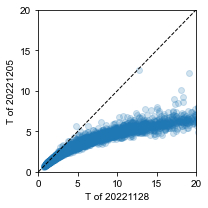

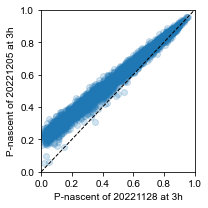

In [46]:
def load_halflife(path):
    df = pd.read_csv(path, sep="\t", index_col=0)
    df = df[df["Canonical"]]
    df = df[df["GeneType"] == "protein_coding"]
    df = df[df[[c for c in columns]].max(axis=1) > 50]
    df = df[df[[c + "_fpkm" for c in columns]].max(axis=1) > 1]
    df = df[df["D"] < 0.3]
    return df
df1 = load_halflife("results/halflife/20221128_AtcD_halflife.tsv")
df2 = load_halflife("results/halflife/20221205_AtcD_halflife.tsv")
print(len(df1), len(df2))

genes = df1.index & df2.index
xs = df1.loc[genes]["T"]
ys = df2.loc[genes]["T"]
plt.figure(figsize=(3, 3))
plt.scatter(xs, ys, alpha=0.2)
plt.plot([0, 20], [0, 20], lw=1, ls="--", color="black")
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.yticks([0, 5, 10, 15, 20])
plt.xlabel("T of 20221128")
plt.ylabel("T of 20221205")
plt.tight_layout()
plt.savefig("figures/T_corr.pdf", dpi=300)

xs = 1 - 2**(-3/xs)
ys = 1 - 2**(-3/ys)
plt.figure(figsize=(3, 3))
plt.scatter(xs, ys, alpha=0.2)
plt.plot([0, 1], [0, 1], lw=1, ls="--", color="black")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("P-nascent of 20221128 at 3h")
plt.ylabel("P-nascent of 20221205 at 3h")
plt.tight_layout()
plt.savefig("figures/P_nascent_corr.pdf", dpi=300)

# Half-life of star genes

In [21]:
df = pd.read_csv("results/halflife/20221128_AtcD_halflife.tsv", sep="\t", index_col=0)
# df = df[df["Canonical"]]
# df = df[df["GeneType"] == "protein_coding"]
# df = df[df[[c for c in columns]].max(axis=1) > 50]
# df = df[df[[c + "_fpkm" for c in columns]].max(axis=1) > 1]
# df.sort_values(by="D")

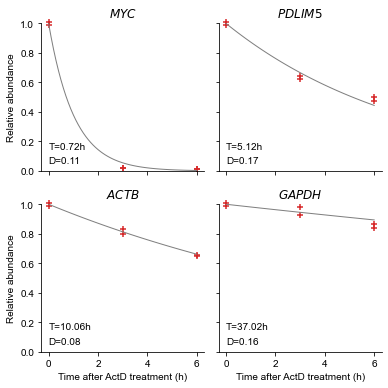

In [38]:
tids = [
    "ENST00000621592.8", # MYC
    "ENST00000317968.9", # PDLIM5
    "ENST00000646664.1", # Actb
    "ENST00000229239.10", # GAPDH
]

fig, axs = plt.subplots(2, 2, figsize=(5.5, 5.5), sharex=True, sharey=True)

for i, tid in enumerate(tids):
    m = int(i / 2)
    n = i % 2
    plt.sca(axs[m][n])
    
    T = df.loc[tid]["T"]
    D = df.loc[tid]["D"]
    gname = df.loc[tid]["GeneName"]
    xs = np.array([0, 0, 3, 3, 6, 6])
    ys = df.loc[tid][["0h-1_adj_p", "0h-2_adj_p", "3h-1_adj_p", "3h-2_adj_p", "6h-1_adj_p", "6h-2_adj_p"]]
    xs1 = np.arange(0, 6.1, 0.1)
    ys1 = np.array([0.5**(x/T)for x in xs1])
    
    # plt.figure(figsize=(2.8, 3))
    plt.title("$\it{%s}$" % gname)
    plt.scatter(xs, ys, color="C3", marker="+", clip_on=False)
    # plt.scatter(xs[[0, 2, 4]], ys[[0, 2, 4]], marker=">", color="C9", clip_on=False)
    # plt.scatter(xs[[1, 3, 5]], ys[[1, 3, 5]], color="C7", clip_on=False)
    plt.plot(xs1, ys1, lw=1, color="C7")
    plt.text(0, 0.15, "T=%.2fh" % T)
    plt.text(0, 0.05, "D=%.2f" % D)
    if m == 1:
        plt.xlabel("Time after ActD treatment (h)")
    if n == 0:
        plt.ylabel("Relative abundance")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("figures/decay_curve.pdf", dpi=300)

# Allele specific degradation

In [45]:
data_factors = json.load(open("results/transform_factor.json"))
dates = ["20221128", "20221205"]
columns = ["0h-1", "0h-2", "3h-1", "3h-2", "6h-1", "6h-2"]

date = dates[0]
samples = []
for t in [0, 3, 6]:
    for r in [1, 2]:
        s = "%s_K562_Actd_%dh_rep%d" % (date, t, r)
        samples.append(s)
array = []
for sample, column in zip(samples, columns):
    d = pd.read_csv("results/snps/counts/%s.tsv" % sample, sep="\t")
    d.index = ["%s:%d" % (chrom, start) for chrom, start in d[["Chrom", "Start"]].values]
    d = d[d.columns[3:]]
    d.columns = ["%s_%s" % (column, c) for c in d.columns]
    array.append(d)
df = pd.concat(array, axis=1, join="outer").fillna(0)

In [80]:
for hp in ["HP1", "HP2"]:
    for column in columns:
        factor = data_factors[date]["%s,0h-1" % column]
        # df["%s_%s" % (column, hp)] * factor
        df["%s_%s_adj" % (column, hp)] = df["%s_%s" % (column, hp)] * factor
        
    mean_0 =  df[["0h-1_%s_adj" % hp, "0h-2_%s_adj" % hp]].mean(axis=1)
    for column in columns:
        df["%s_%s_adj_p" % (column, hp)] = df["%s_%s_adj" % (column, hp)] / mean_0
        
    Ts = []
    Ds = []
    for vs in df[[c + "_%s_adj_p" % hp for c in columns]].values:
        xs0 = [0, 0, 3, 3, 6, 6]
        ys0 = vs
        ys = ys0[2:]
        xs = np.array([3, 3, 6, 6])
        Y = np.log2(-np.log2(ys))
        X = np.log2(xs)
        b = sum(Y - X) / len(Y)
        T = 1 / (2 ** b)
        D = sum([abs(y - 2 ** (-x/T)) for x, y in zip(xs0, ys0)])
        Ts.append(T)
        Ds.append(D)
    df["T_%s" % hp] = Ts
    df["D_%s" % hp] = Ds
    df["P_Nascent_%s" % hp] = 1 - 0.5 ** (3 / df["T_%s" % hp])
    df["K_%s" % hp] = mean_0 / df["T_%s" % hp] * np.log(2)

/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log2
/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2
/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/home/chenzonggui/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


In [81]:
df1 = df[(df["0h-1_Assigned%"] > 0.95) & (df["0h-2_Assigned%"] > 0.95)] # assigned
df1 = df1[(df1["0h-1_Log2FC"].abs() < 2) & (df1["0h-2_Log2FC"].abs() < 2)]
df1 = df1[(df1["D_HP1"] < 0.2) & (df1["D_HP2"] < 0.2)]
df1

,0h-1_UnAssinged,0h-1_HP1,0h-1_HP2,0h-1_Assigned,0h-1_Assigned%,0h-1_Log2FC,0h-2_UnAssinged,0h-2_HP1,0h-2_HP2,0h-2_Assigned,...,6h-1_HP2_adj_p,6h-2_HP2_adj_p,T_HP1,D_HP1,T_HP2,D_HP2,P_Nascent_HP1,P_Nascent_HP2,K_HP1,K_HP2
chr1:2308943,0,38,33,71,1.000000,0.203533,1,38,36,74,...,0.032133,0.043604,1.443515,0.053451,1.409918,0.166829,0.763200,0.771191,18.041512,16.761817
chr1:42926578,2,213,354,567,0.996485,-0.732896,1,210,338,548,...,0.118457,0.121645,2.002636,0.079319,2.016026,0.103092,0.645962,0.643512,72.385907,117.653544
chr1:42929963,0,212,277,489,1.000000,-0.385822,0,218,316,534,...,0.117804,0.130256,1.847667,0.105555,2.127734,0.192365,0.675491,0.623675,79.736362,95.431741
chr1:42930742,2,195,301,496,0.995984,-0.626289,1,210,321,531,...,0.167512,0.132196,2.042205,0.111158,2.157529,0.176763,0.638767,0.618562,67.928684,98.754181
chr1:65392461,0,100,39,139,1.000000,1.358454,0,92,42,134,...,0.095796,0.061902,1.449124,0.172438,1.567438,0.140376,0.761876,0.734635,45.423662,17.700770
chr1:150966094,4,428,233,661,0.993985,0.877281,4,446,233,679,...,0.661010,0.613049,8.150978,0.091018,10.496497,0.177152,0.225173,0.179719,36.735046,15.213257
chr1:203852185,0,106,53,159,1.000000,1.000000,0,113,54,167,...,0.176060,0.215490,2.780268,0.129937,2.360902,0.107709,0.526654,0.585542,26.982371,15.528887
chr1:230281203,3,56,138,194,0.984772,-1.301170,2,57,130,187,...,0.661282,0.646845,20.126840,0.168276,8.933353,0.170509,0.098159,0.207666,1.923711,10.283679
chr1:230281917,0,35,91,126,1.000000,-1.378512,0,36,96,132,...,0.628269,0.697060,7.428705,0.139864,9.119671,0.158591,0.244156,0.203889,3.274585,7.024428
chr1:241872135,0,139,56,195,1.000000,1.311586,0,137,55,192,...,0.119774,0.117385,2.042249,0.124094,1.727890,0.183848,0.638760,0.699845,46.314500,22.015685


limit_output extension: Maximum message size of 10000 exceeded with 31699 characters

In [82]:
df1[["0h-1_HP1_adj", "0h-2_HP1_adj", "0h-1_HP2_adj", "0h-2_HP2_adj", "T_HP1", "T_HP2", "P_Nascent_HP1", "P_Nascent_HP2"]]

,0h-1_HP1_adj,0h-2_HP1_adj,0h-1_HP2_adj,0h-2_HP2_adj,T_HP1,T_HP2,P_Nascent_HP1,P_Nascent_HP2
chr1:2308943,38.0,37.144779,33.0,35.189791,1.443515,1.409918,0.763200,0.771191
chr1:42926578,213.0,205.273781,354.0,330.393038,2.002636,2.016026,0.645962,0.643512
chr1:42929963,212.0,213.093735,277.0,308.888166,1.847667,2.127734,0.675491,0.623675
chr1:42930742,195.0,205.273781,301.0,313.775637,2.042205,2.157529,0.638767,0.618562
chr1:65392461,100.0,89.929466,39.0,41.054756,1.449124,1.567438,0.761876,0.734635
chr1:150966094,428.0,435.962411,233.0,227.756148,8.150978,10.496497,0.225173,0.179719
chr1:203852185,106.0,110.456844,53.0,52.784687,2.780268,2.360902,0.526654,0.585542
chr1:230281203,56.0,55.717169,138.0,127.074245,20.126840,8.933353,0.098159,0.207666
chr1:230281917,35.0,35.189791,91.0,93.839443,7.428705,9.119671,0.244156,0.203889
chr1:241872135,139.0,133.916705,56.0,53.762181,2.042249,1.727890,0.638760,0.699845


limit_output extension: Maximum message size of 10000 exceeded with 15089 characters

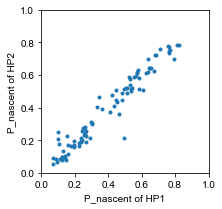

In [83]:
xs = df1["P_Nascent_HP1"]
ys = df1["P_Nascent_HP2"]
plt.figure(figsize=(3, 3))
plt.scatter(xs, ys, marker=".")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("P_nascent of HP1")
plt.ylabel("P_nascent of HP2")
plt.show()

In [85]:
df1[df1["P_Nascent_HP1"] / df1["P_Nascent_HP2"] > 2].iloc[0]

0h-1_UnAssinged      2.000000
0h-1_HP1           165.000000
0h-1_HP2            65.000000
0h-1_Assigned      230.000000
0h-1_Assigned%       0.991379
0h-1_Log2FC          1.343954
0h-2_UnAssinged      6.000000
0h-2_HP1           187.000000
0h-2_HP2            66.000000
0h-2_Assigned      253.000000
0h-2_Assigned%       0.976834
0h-2_Log2FC          1.502500
3h-1_UnAssinged      5.000000
3h-1_HP1           145.000000
3h-1_HP2            80.000000
3h-1_Assigned      225.000000
3h-1_Assigned%       0.978261
3h-1_Log2FC          0.857981
3h-2_UnAssinged      2.000000
3h-2_HP1           120.000000
3h-2_HP2            72.000000
3h-2_Assigned      192.000000
3h-2_Assigned%       0.989691
3h-2_Log2FC          0.736966
6h-1_UnAssinged      4.000000
6h-1_HP1            82.000000
6h-1_HP2            75.000000
6h-1_Assigned      157.000000
6h-1_Assigned%       0.975155
6h-1_Log2FC          0.128733
                      ...    
3h-1_HP1_adj        93.253383
3h-2_HP1_adj        84.084285
6h-1_HP1_a